# Proyecto final

## Descripción del proyecto

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

**Servicios de Interconnect**

Interconnect proporciona principalmente dos tipos de servicios:
1.	Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2.	Internet. La red se puede configurar a través de una línea telefónica (DSL, línea de abonado digital) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (ProtecciónDeDispositivo) y un bloqueador de sitios web maliciosos (SeguridadEnLínea).
- Una línea de soporte técnico (SoporteTécnico).
- Almacenamiento de archivos en la nube y backup de datos (BackupOnline).
- Streaming de TV (StreamingTV) y directorio de películas (StreamingPelículas)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

**Objetivo**: Pronosticar los clientes que tienen probabilidad de irse para ofrecer códigos promocionales.

Para cumplir el objetivo, vamos a seguir estos pasos:

- Carga de los datos: cargar los 4 archivos csv para la manipulaciónde estos.

- EDA: Cambio de formato a las columnas por ejemplo: formato de fecha, flotante, object, etc. Vamos a unir todos los dataframes en uno solo para determinar los clientes que tiene cada uno de los diferentes servicios. Después vamos dividir dicha base en dos los activos y los dados de baja. Trabajaremos con ambas secciones para encontrar patrones, ver la proporción de las categorías y ver si hay alguna con mayor peso que otra y por último ver si hay colinealidad o correlaciones para determinar que variables podemos eliminar y tener menos ruido en los modelos.
Dada las columnas de cada dataframe podemos crear algunas hipótesis con respecto a cuáles tendrán mayor relevancia como parte del entrenamiento de los modelos estas son: 
    - Type: que es la periodicidad del pago
    - PaymentMethod: método de pago
    - SeniorCitizen: Si es mayor de 60 años
    - MultipleLines: Si cuenta con una línea telefónica o varias.
    - InternetService: por que medio se le brinda el servicio de internet

    Durante el proceso de EDA veremos si fueron correctas estás hipótesis o no. Tambén vamos a estandarizar, realizar One-Hot y dividir la base en 75 y 25 para la parte de entrenamiento y validación. Para la obtención de los mejores hiperparámetros vamos a usar GridSearchCV por ello solo vamos a dividir en dos la base.
    
- Creación de modelos:

    - Arbol de decisión
    - Bosque aleatorio
    - Regresión logística
    - Boosting
    - Red neuronal
- Determinar que modelo tuvo mejor resultado bajo las métricas; AUC-ROC, exactitud.
- Conclusiones


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.base import BaseEstimator


## Carga de Datos

In [2]:
try:
    contrato= pd.read_csv("contract.csv")
    personal= pd.read_csv("personal.csv")
    internet= pd.read_csv("internet.csv")
    phone= pd.read_csv("phone.csv")
    
except:
    contrato= pd.read_csv("/dataset/contract.csv")
    personal= pd.read_csv("/dataset/personal.csv")
    internet= pd.read_csv("/dataset/internet.csv")
    phone= pd.read_csv("/dataset/phone.csv")

print(contrato.shape)
print(personal.shape)
print(internet.shape)
print(phone.shape)


(7043, 8)
(7043, 5)
(5517, 8)
(6361, 2)


In [3]:
display(contrato.head())
display(personal.head())
display(internet.head())
display(phone.head())

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

## Analisís Exploratorio de Datos (EDA)

### Revision del dataframe contrato

In [4]:
print(contrato.info())
print("-"*50)
print(contrato.describe())
print(contrato["TotalCharges"].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
--------------------------------------------------
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000
count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object


In [5]:
print(contrato["TotalCharges"].sum())
#print(contrato["TotalCharges"].mean())
print()
print(contrato["MonthlyCharges"].sum())

29.851889.5108.151840.75151.65820.51949.4301.93046.053487.95587.45326.85681.15036.32686.057895.151022.957382.25528.351862.939.65202.2520.153505.12970.31530.64749.1530.26369.451093.16766.95181.651874.4520.245.257251.7316.93548.33549.251105.4475.74872.35418.254861.45981.453906.797144.154217.84254.13838.751426.41752.65633.34456.351752.556311.27076.35894.37853.74707.15450.72962957.1857.25244.13650.352497.2930.9887.3549.051090.6570991424.6177.46139.52688.85482.252111.31216.679.35565.35496.94327.5973.35918.752215.451057927.11009.252570.274.75714.2571077459.05927.354748.7113.851107.22514.520.219.453605.63027.257611.85100.27303.05927.653921.31363.255238.93042.253954.12868.153423.5248.41126.351064.65835.152151.65515.45112.75229.55350.3562.93027.652135.51723.9519.753985.351215.651502.653260.135.4581.251188.21778.51277.751170.5570.456425.65563.655971.255289.051756.26416.761.3545.651929.951071.4564.35655.57930.555215.25113.51152.81821.95419.91024251.6764.551592.35135.23958.25233.91363.452736254.45

**Nota** 
- No hay filas duplicadas
- Cambiar las columnas BeginDate a fecha. Para la fecha de finalización no se puede dar formato de fecha ya que está el string "No", por lo que vamos hacer dos tablas uno con los vigentes y otra con los dados de baja para ver tiempo que duro con el servicio, montos de pago, etc y así inferir patrones.
- TotalCharges cambiar a float. Vemos que tiene error en los valores ya que no deja sumar o hacer operaciones en el dado que tiene valores nulos

In [6]:
contrato["TotalCharges"]= pd.to_numeric(contrato["TotalCharges"], errors= "coerce")
print(contrato["TotalCharges"].sum(), contrato["TotalCharges"].mean())
print(contrato.info())
print("-"*50)
print(contrato.describe())

16056168.7 2283.3004408418656
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
None
--------------------------------------------------
       MonthlyCharges  TotalCharges
count     7043.000000   7032.000000
mean        64.761692   2283.300441
std         30.090047   2266.771362
min         18.250000     18.800000
25%         35.500000    401.450000
50%         70.350000   1397.475000
75%         89.850000   3794.737

In [7]:
display(contrato[contrato["TotalCharges"].isnull()])

customerID   BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              Yes   
753   3115-CZMZD  2020-02-01      No  Two year               No   
936   5709-LVOEQ  2020-02-01      No  Two year               No   
1082  4367-NUYAO  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   
3331  7644-OMVMY  2020-02-01      No  Two year               No   
3826  3213-VVOLG  2020-02-01      No  Two year               No   
4380  2520-SGTTA  2020-02-01      No  Two year               No   
5218  2923-ARZLG  2020-02-01      No  One year              Yes   
6670  4075-WKNIU  2020-02-01      No  Two year               No   
6754  2775-SEFEE  2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  
488   Bank transfer (automatic)           52.55           NaN  
753                Mailed check           20.25           NaN  
936                Mailed check           80.85           NaN  
1082               Mailed check           25.75           NaN  
1340    Credit card (automatic)           56.05           NaN  
3331               Mailed check           19.85           NaN  
3826               Mailed check           25.35           NaN  
4380               Mailed check           20.00           NaN  
5218               Mailed check           19.70           NaN  
6670               Mailed check           73.35           NaN  
6754  Bank transfer (automatic)           61.90           NaN

Vemos que tenemos valores nulos en la fecha de en que se nos dio la base de datos por lo que podemos elimar estas filas.

In [8]:
contrato= contrato.dropna(subset=["TotalCharges"])
print(contrato.info())


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 494.4+ KB
None


In [9]:
contrato["BeginDate"]= pd.to_datetime(contrato["BeginDate"], format= "%Y-%m-%d")
print(contrato.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 494.4+ KB
None


In [10]:
#Ver filas duplicadas
print(contrato.duplicated().sum())
#print(contrato["customerID"].value_counts())

0


In [11]:
print(contrato["customerID"].duplicated().sum())
print(contrato["customerID"].value_counts())

0
customerID
7590-VHVEG    1
0265-PSUAE    1
2956-GGUCQ    1
6008-NAIXK    1
5956-YHHRX    1
             ..
7874-ECPQJ    1
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
3186-AJIEK    1
Name: count, Length: 7032, dtype: int64


### Revisión de los dataframes categoricos

Queda claro que los dataframes personal, internet y phone; sus columnas son categóricas por lo que sólo vamos a revisa valores nulos y filas dupliacadas.

### Dataframe personal

In [12]:
print(personal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


In [13]:
print(personal.describe(include= "all"))
print()
print("Flias duplicadas", personal.duplicated().sum())
print("-"*50)
print(personal["SeniorCitizen"].sum())
print(personal["SeniorCitizen"].count())

        customerID gender  SeniorCitizen Partner Dependents
count         7043   7043    7043.000000    7043       7043
unique        7043      2            NaN       2          2
top     7590-VHVEG   Male            NaN      No         No
freq             1   3555            NaN    3641       4933
mean           NaN    NaN       0.162147     NaN        NaN
std            NaN    NaN       0.368612     NaN        NaN
min            NaN    NaN       0.000000     NaN        NaN
25%            NaN    NaN       0.000000     NaN        NaN
50%            NaN    NaN       0.000000     NaN        NaN
75%            NaN    NaN       0.000000     NaN        NaN
max            NaN    NaN       1.000000     NaN        NaN

Flias duplicadas 0
--------------------------------------------------
1142
7043


In [14]:
#cambiar la columna de SeniorCitizen a valores booleanos
personal["SeniorCitizen"] = personal["SeniorCitizen"].astype(bool)
personal["SeniorCitizen"] = personal["SeniorCitizen"].astype(str)
print(personal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB
None


In [15]:
personal_proporciones = personal.apply(lambda col: col.value_counts(normalize= True))
print(personal_proporciones)

            customerID    gender  SeniorCitizen   Partner  Dependents
0002-ORFBO    0.000142       NaN            NaN       NaN         NaN
0003-MKNFE    0.000142       NaN            NaN       NaN         NaN
0004-TLHLJ    0.000142       NaN            NaN       NaN         NaN
0011-IGKFF    0.000142       NaN            NaN       NaN         NaN
0013-EXCHZ    0.000142       NaN            NaN       NaN         NaN
...                ...       ...            ...       ...         ...
Female             NaN  0.495244            NaN       NaN         NaN
Male               NaN  0.504756            NaN       NaN         NaN
No                 NaN       NaN            NaN  0.516967    0.700412
True               NaN       NaN       0.162147       NaN         NaN
Yes                NaN       NaN            NaN  0.483033    0.299588

[7049 rows x 5 columns]


In [16]:
display(personal)

customerID  gender SeniorCitizen Partner Dependents
0     7590-VHVEG  Female         False     Yes         No
1     5575-GNVDE    Male         False      No         No
2     3668-QPYBK    Male         False      No         No
3     7795-CFOCW    Male         False      No         No
4     9237-HQITU  Female         False      No         No
...          ...     ...           ...     ...        ...
7038  6840-RESVB    Male         False     Yes        Yes
7039  2234-XADUH  Female         False     Yes        Yes
7040  4801-JZAZL  Female         False     Yes        Yes
7041  8361-LTMKD    Male          True     Yes         No
7042  3186-AJIEK    Male         False      No         No

[7043 rows x 5 columns]

Conclusiones:
- No teniamos filas duplicadas

### Dataframe internet

In [17]:
print(internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


**nota**: tenemos menos clientes que en el registro de clientes completo, por lo que podemos ver que clientes no tienen servicio de internet

In [18]:
print(internet.describe(include= "all"))
print()
print("Flias duplicadas", internet.duplicated().sum())

        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785  

Flias duplicadas 0


In [19]:
display(internet)

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0     7590-VHVEG             DSL             No          Yes               No   
1     5575-GNVDE             DSL            Yes           No              Yes   
2     3668-QPYBK             DSL            Yes          Yes               No   
3     7795-CFOCW             DSL            Yes           No              Yes   
4     9237-HQITU     Fiber optic             No           No               No   
...          ...             ...            ...          ...              ...   
5512  6840-RESVB             DSL            Yes           No              Yes   
5513  2234-XADUH     Fiber optic             No          Yes              Yes   
5514  4801-JZAZL             DSL            Yes           No               No   
5515  8361-LTMKD     Fiber optic             No           No               No   
5516  3186-AJIEK     Fiber optic            Yes           No              Yes   

     TechSupport StreamingTV StreamingMovies  
0             No          No              No  
1             No          No              No  
2             No          No              No  
3            Yes          No              No  
4             No          No              No  
...          ...         ...             ...  
5512         Yes         Yes             Yes  
5513          No         Yes             Yes  
5514          No          No              No  
5515          No          No              No  
5516         Yes         Yes             Yes  

[5517 rows x 8 columns]

### Dataframe phone

In [20]:
print(phone.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


**nota**: tenemos menos clientes que en el registro de clientes completo, por lo que podemos ver que clientes no tienen servicio de phone

In [21]:
print(internet.describe(include= "all"))
print()
print("Flias duplicadas", internet.duplicated().sum())

        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785  

Flias duplicadas 0


In [22]:
display(internet)

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0     7590-VHVEG             DSL             No          Yes               No   
1     5575-GNVDE             DSL            Yes           No              Yes   
2     3668-QPYBK             DSL            Yes          Yes               No   
3     7795-CFOCW             DSL            Yes           No              Yes   
4     9237-HQITU     Fiber optic             No           No               No   
...          ...             ...            ...          ...              ...   
5512  6840-RESVB             DSL            Yes           No              Yes   
5513  2234-XADUH     Fiber optic             No          Yes              Yes   
5514  4801-JZAZL             DSL            Yes           No               No   
5515  8361-LTMKD     Fiber optic             No           No               No   
5516  3186-AJIEK     Fiber optic            Yes           No              Yes   

     TechSupport StreamingTV StreamingMovies  
0             No          No              No  
1             No          No              No  
2             No          No              No  
3            Yes          No              No  
4             No          No              No  
...          ...         ...             ...  
5512         Yes         Yes             Yes  
5513          No         Yes             Yes  
5514          No          No              No  
5515          No          No              No  
5516         Yes         Yes             Yes  

[5517 rows x 8 columns]

**Conclusión:**
Con respecto a los dataframes que tienen columnas categoricas no hay problema alguno, todas están en formato object.

Lo que vamos hacer es unir todas los dataframes en uno solo para determinar los clientes que tiene cada uno de los diferentes servicios. Después vamos divir dicha base en dos los activos y los dado de baja. Trabajaremos con los dado de baja para ver si encontramos patrones, ver la proporción de las categorías y ver si hay alguna con mayor peso que otra y por último ver si hay colinealidad o correlaciones para determinar que variables podemos eliminar y tener menos ruido en los modelos.

### Unión del dataframe

In [23]:
union_1= contrato.merge(personal, on= "customerID", how= "left")
union_2 = union_1.merge(phone, on= "customerID", how= "left")
df = union_2.merge(internet, on="customerID", how= "left")

def clasificar(x):
    if x == "No":
        return 0
    else:
        return 1

df["objetivo"]= df["EndDate"].apply(clasificar) 
display(df) 

customerID  BeginDate              EndDate            Type  \
0     7590-VHVEG 2020-01-01                   No  Month-to-month   
1     5575-GNVDE 2017-04-01                   No        One year   
2     3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW 2016-05-01                   No        One year   
4     9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...        ...                  ...             ...   
7027  6840-RESVB 2018-02-01                   No        One year   
7028  2234-XADUH 2014-02-01                   No        One year   
7029  4801-JZAZL 2019-03-01                   No  Month-to-month   
7030  8361-LTMKD 2019-07-01  2019-11-01 00:00:00  Month-to-month   
7031  3186-AJIEK 2014-08-01                   No        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges  \
0                 Yes           Electronic check           29.85   
1                  No               Mailed check           56.95   
2                 Yes               Mailed check           53.85   
3                  No  Bank transfer (automatic)           42.30   
4                 Yes           Electronic check           70.70   
...               ...                        ...             ...   
7027              Yes               Mailed check           84.80   
7028              Yes    Credit card (automatic)          103.20   
7029              Yes           Electronic check           29.60   
7030              Yes               Mailed check           74.40   
7031              Yes  Bank transfer (automatic)          105.65   

      TotalCharges  gender SeniorCitizen  ... Dependents MultipleLines  \
0            29.85  Female         False  ...         No           NaN   
1          1889.50    Male         False  ...         No            No   
2           108.15    Male         False  ...         No            No   
3          1840.75    Male         False  ...         No           NaN   
4           151.65  Female         False  ...         No            No   
...            ...     ...           ...  ...        ...           ...   
7027       1990.50    Male         False  ...        Yes           Yes   
7028       7362.90  Female         False  ...        Yes           Yes   
7029        346.45  Female         False  ...        Yes           NaN   
7030        306.60    Male          True  ...         No           Yes   
7031       6844.50    Male         False  ...         No            No   

     InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0                DSL             No          Yes               No          No   
1                DSL            Yes           No              Yes          No   
2                DSL            Yes          Yes               No          No   
3                DSL            Yes           No              Yes         Yes   
4        Fiber optic             No           No               No          No   
...              ...            ...          ...              ...         ...   
7027             DSL            Yes           No              Yes         Yes   
7028     Fiber optic             No          Yes              Yes          No   
7029             DSL            Yes           No               No          No   
7030     Fiber optic             No           No               No          No   
7031     Fiber optic            Yes           No              Yes         Yes   

     StreamingTV StreamingMovies objetivo  
0             No              No        0  
1             No              No        0  
2             No              No        1  
3             No              No        0  
4             No              No        1  
...          ...             ...      ...  
7027         Yes             Yes        0  
7028         Yes             Yes        0  
7029          No              No        0  
7030          No              No        1  
7031         Yes          

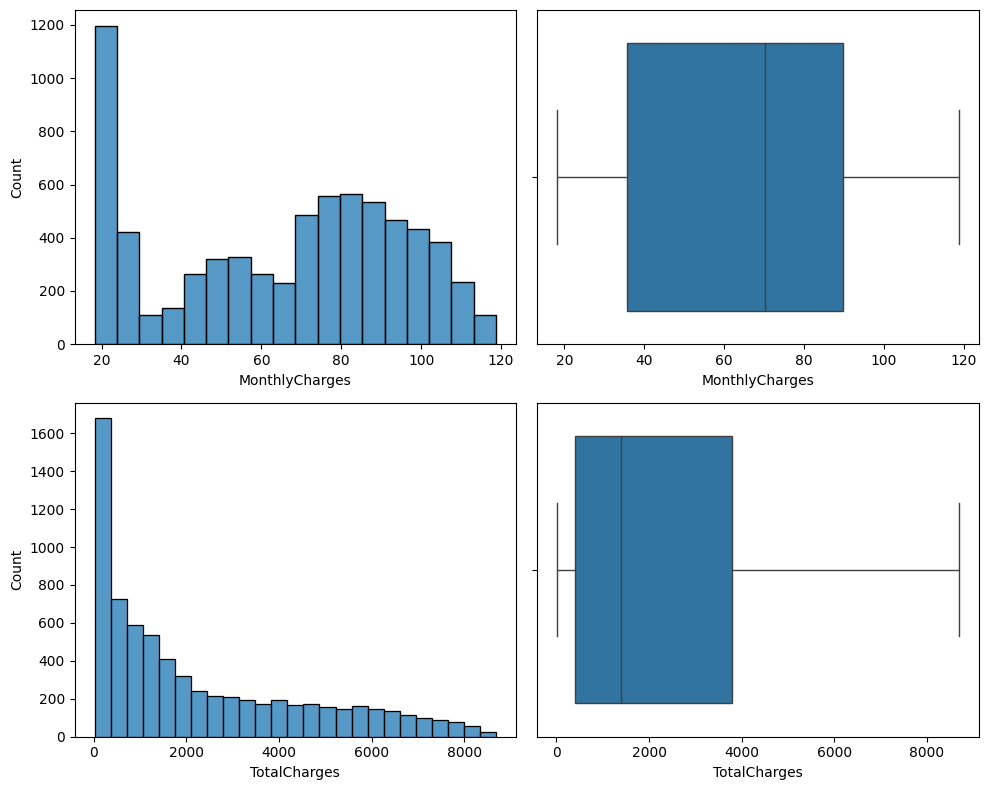

In [24]:
## histogramas
figura, cuadrantes= plt.subplots(2,2, figsize=(10,8))

sns.histplot(data = df, x ='MonthlyCharges', ax = cuadrantes[0,0])
sns.histplot(data = df, x ='TotalCharges', ax = cuadrantes[1,0])
sns.boxplot(data = df, x='MonthlyCharges',ax = cuadrantes[0,1])
sns.boxplot(data = df, x='TotalCharges',ax = cuadrantes[1,1])

plt.tight_layout()
plt.show()


In [25]:
df_categoricas= df.drop(["customerID", "BeginDate", "EndDate", "MonthlyCharges", "TotalCharges", "objetivo"], axis= "columns")
df_categoricas_proporciones = df_categoricas.apply(lambda col: col.value_counts(dropna= False ,normalize= True).round(2))
display(df_categoricas_proporciones)

Type  PaperlessBilling  PaymentMethod  gender  \
Bank transfer (automatic)   NaN               NaN           0.22     NaN   
Credit card (automatic)     NaN               NaN           0.22     NaN   
DSL                         NaN               NaN            NaN     NaN   
Electronic check            NaN               NaN           0.34     NaN   
False                       NaN               NaN            NaN     NaN   
Female                      NaN               NaN            NaN     0.5   
Fiber optic                 NaN               NaN            NaN     NaN   
Mailed check                NaN               NaN           0.23     NaN   
Male                        NaN               NaN            NaN     0.5   
Month-to-month             0.55               NaN            NaN     NaN   
No                          NaN              0.41            NaN     NaN   
One year                   0.21               NaN            NaN     NaN   
True                        NaN               NaN            NaN     NaN   
Two year                   0.24               NaN            NaN     NaN   
Yes                         NaN              0.59            NaN     NaN   
NaN                         NaN               NaN            NaN     NaN   

                           SeniorCitizen  Partner  Dependents  MultipleLines  \
Bank transfer (automatic)            NaN      NaN         NaN            NaN   
Credit card (automatic)              NaN      NaN         NaN            NaN   
DSL                                  NaN      NaN         NaN            NaN   
Electronic check                     NaN      NaN         NaN            NaN   
False                               0.84      NaN         NaN            NaN   
Female                               NaN      NaN         NaN            NaN   
Fiber optic                          NaN      NaN         NaN            NaN   
Mailed check                         NaN      NaN         NaN            NaN   
Male                                 NaN      NaN         NaN            NaN   
Month-to-month                       NaN      NaN         NaN            NaN   
No                                   NaN     0.52         0.7           0.48   
One year                             NaN      NaN         NaN            NaN   
True                                0.16      NaN         NaN            NaN   
Two year                             NaN      NaN         NaN            NaN   
Yes                                  NaN     0.48         0.3           0.42   
NaN                                  NaN      NaN         NaN           0.10   

                           InternetService  OnlineSecurity  OnlineBackup  \
Bank transfer (automatic)              NaN             NaN           NaN   
Credit card (automatic)                NaN             NaN           NaN   
DSL                                   0.34             NaN           NaN   
Electronic check                       NaN             NaN           NaN   
False                                  NaN             NaN           NaN   
Female                                 NaN             NaN           NaN   
Fiber optic                           0.44             NaN           NaN   
Mailed check                           NaN             NaN           NaN   
Male                                   NaN             NaN           NaN   
Month-to-month                         NaN             NaN           NaN   
No                                     NaN            0.50          0.44   
One year                               NaN             NaN           NaN   
True                                   NaN             NaN           NaN   
Two year                               NaN             NaN           NaN   
Yes                                    NaN            0.29          0.34   
NaN                                   0.22            0.22          0.22   

                           DeviceProtection  TechSupport  StreamingTV  \
Bank tr

**Notas**
- El 10% de los clientes no tienen el servicio de linea telefonica
- El 22% de los clientes no tienen el servicio de internet
- Los clientes deben tener almenos un servicio: telefonia o internet


### Divsión en clientes vivos y cancelados

In [26]:
df_vivos= df[df["EndDate"] == "No"]
display(df_vivos)

customerID  BeginDate EndDate            Type PaperlessBilling  \
0     7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
1     5575-GNVDE 2017-04-01      No        One year               No   
3     7795-CFOCW 2016-05-01      No        One year               No   
6     1452-KIOVK 2018-04-01      No  Month-to-month              Yes   
7     6713-OKOMC 2019-04-01      No  Month-to-month               No   
...          ...        ...     ...             ...              ...   
7026  2569-WGERO 2014-02-01      No        Two year              Yes   
7027  6840-RESVB 2018-02-01      No        One year              Yes   
7028  2234-XADUH 2014-02-01      No        One year              Yes   
7029  4801-JZAZL 2019-03-01      No  Month-to-month              Yes   
7031  3186-AJIEK 2014-08-01      No        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  gender  \
0              Electronic check           29.85         29.85  Female   
1                  Mailed check           56.95       1889.50    Male   
3     Bank transfer (automatic)           42.30       1840.75    Male   
6       Credit card (automatic)           89.10       1949.40    Male   
7                  Mailed check           29.75        301.90  Female   
...                         ...             ...           ...     ...   
7026  Bank transfer (automatic)           21.15       1419.40  Female   
7027               Mailed check           84.80       1990.50    Male   
7028    Credit card (automatic)          103.20       7362.90  Female   
7029           Electronic check           29.60        346.45  Female   
7031  Bank transfer (automatic)          105.65       6844.50    Male   

     SeniorCitizen  ... Dependents MultipleLines InternetService  \
0            False  ...         No           NaN             DSL   
1            False  ...         No            No             DSL   
3            False  ...         No           NaN             DSL   
6            False  ...        Yes           Yes     Fiber optic   
7            False  ...         No           NaN             DSL   
...            ...  ...        ...           ...             ...   
7026         False  ...         No            No             NaN   
7027         False  ...        Yes           Yes             DSL   
7028         False  ...        Yes           Yes     Fiber optic   
7029         False  ...        Yes           NaN             DSL   
7031         False  ...         No            No     Fiber optic   

     OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0                No          Yes               No          No          No   
1               Yes           No              Yes          No          No   
3               Yes           No              Yes         Yes          No   
6                No          Yes               No          No         Yes   
7               Yes           No               No          No          No   
...             ...          ...              ...         ...         ...   
7026            NaN          NaN              NaN         NaN         NaN   
7027            Yes           No              Yes         Yes         Yes   
7028             No          Yes              Yes          No         Yes   
7029            Yes           No               No          No          No   
7031            Yes           No              Yes         Yes         Yes   

     StreamingMovies objetivo  
0                 No        0  
1                 No        0  
3                 No        0  
6                 No        0  
7                 No        0  
...              ...      ...  
7026             NaN        0  
7027             Yes        0  
7028             Yes        0  
7029              No        0  
7031             Yes        0  

[5163 rows x 21 columns]

In [27]:
df_cancelado= df[df["EndDate"] != "No"]
display(df_cancelado)

customerID  BeginDate              EndDate            Type  \
2     3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
4     9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   
5     9305-CDSKC 2019-03-01  2019-11-01 00:00:00  Month-to-month   
8     7892-POOKP 2017-07-01  2019-11-01 00:00:00  Month-to-month   
13    0280-XJGEX 2015-09-01  2019-10-01 00:00:00  Month-to-month   
...          ...        ...                  ...             ...   
7010  1699-HPSBG 2018-11-01  2019-11-01 00:00:00        One year   
7015  8775-CEBBJ 2019-02-01  2019-11-01 00:00:00  Month-to-month   
7021  6894-LFHLY 2019-10-01  2019-11-01 00:00:00  Month-to-month   
7023  0639-TSIQW 2014-03-01  2019-10-01 00:00:00  Month-to-month   
7030  8361-LTMKD 2019-07-01  2019-11-01 00:00:00  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges  \
2                 Yes               Mailed check           53.85   
4                 Yes           Electronic check           70.70   
5                 Yes           Electronic check           99.65   
8                 Yes           Electronic check          104.80   
13                Yes  Bank transfer (automatic)          103.70   
...               ...                        ...             ...   
7010              Yes           Electronic check           59.80   
7015              Yes  Bank transfer (automatic)           44.20   
7021              Yes           Electronic check           75.75   
7023              Yes    Credit card (automatic)          102.95   
7030              Yes               Mailed check           74.40   

      TotalCharges  gender SeniorCitizen  ... Dependents MultipleLines  \
2           108.15    Male         False  ...         No            No   
4           151.65  Female         False  ...         No            No   
5           820.50  Female         False  ...         No           Yes   
8          3046.05  Female         False  ...         No           Yes   
13         5036.30    Male         False  ...         No           Yes   
...            ...     ...           ...  ...        ...           ...   
7010        727.80    Male         False  ...         No            No   
7015        403.35  Female         False  ...         No            No   
7021         75.75    Male          True  ...         No           Yes   
7023       6886.25  Female         False  ...         No           Yes   
7030        306.60    Male          True  ...         No           Yes   

     InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
2                DSL            Yes          Yes               No          No   
4        Fiber optic             No           No               No          No   
5        Fiber optic             No           No              Yes          No   
8        Fiber optic             No           No              Yes         Yes   
13       Fiber optic             No          Yes              Yes          No   
...              ...            ...          ...              ...         ...   
7010             DSL             No           No               No         Yes   
7015             DSL             No           No               No          No   
7021     Fiber optic             No           No               No          No   
7023     Fiber optic            Yes          Yes              Yes          No   
7030     Fiber optic             No           No               No          No   

     StreamingTV StreamingMovies objetivo  
2             No              No        1  
4             No              No        1  
5            Yes             Yes        1  
8            Yes             Yes        1  
13           Yes             Yes        1  
...          ...             ...      ...  
7010         Yes              No        1  
7015          No              No        1  
7021          No              No        1  
7023         Yes              No        1  
7030          No          

**Observaciones**
- De nuestra base de 7043 clientes tenemos 5174 dando servicio y 1869 que han cancelado en porcentajes seria 73% y 27% respectivamente.


In [28]:
print(df_vivos[df_vivos["InternetService"].isna()]["MultipleLines"].count())
print(df_vivos[df_vivos["MultipleLines"].isna()]["InternetService"].count())
print(df_vivos.dropna(subset=["MultipleLines", "InternetService"])["InternetService"].count())

1407
510
3246


In [29]:
print(df_cancelado[df_cancelado["InternetService"].isna()]["MultipleLines"].count())
print(df_cancelado[df_cancelado["MultipleLines"].isna()]["InternetService"].count())
print(df_cancelado.dropna(subset=["MultipleLines", "InternetService"])["InternetService"].count())

113
170
1586


In [30]:
servicios = pd.DataFrame({"vivos": [1413, 512, 3249], "cancelados":[113,170,1586]}, index=["Telefonía", "Internet", "Ambos servicios"])
servicios["Total"]= servicios["vivos"] + servicios["cancelados"]
display(servicios)
servicios_porcentaje= pd.DataFrame()
servicios_porcentaje["%_vivos"] = (servicios["vivos"]/df_vivos.shape[0]).round(2)
servicios_porcentaje["%_cancelados"] = (servicios["cancelados"]/df_cancelado.shape[0]).round(2)
display(servicios_porcentaje)



vivos  cancelados  Total
Telefonía         1413         113   1526
Internet           512         170    682
Ambos servicios   3249        1586   4835

%_vivos  %_cancelados
Telefonía           0.27          0.06
Internet            0.10          0.09
Ambos servicios     0.63          0.85

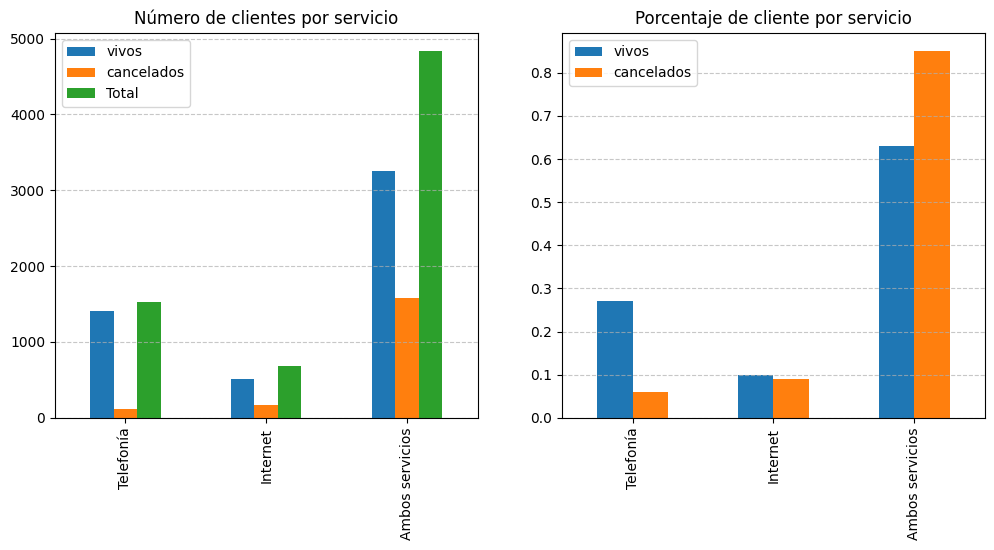

In [31]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

servicios.plot(kind="bar", ax= axes[0])
axes[0].set_title("Número de clientes por servicio")
axes[0].legend(["vivos", "cancelados", "Total"])
axes[0].grid(True, axis='y', linestyle='--', alpha=0.7)

servicios_porcentaje.plot(kind="bar", ax= axes[1])
axes[1].set_title("Porcentaje de cliente por servicio")
axes[1].legend(["vivos", "cancelados"])
axes[1].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()

Por la gráfica anterior, podemos decir:
- 1 de cada 3 clientes que tienen ambos servicios cancela el contrato. 
- De los clientes que solo tienen telefonía 1 de cada 10 cancelan.
- Y los clientes con sólo internet 1 de 4 clientes cancelan

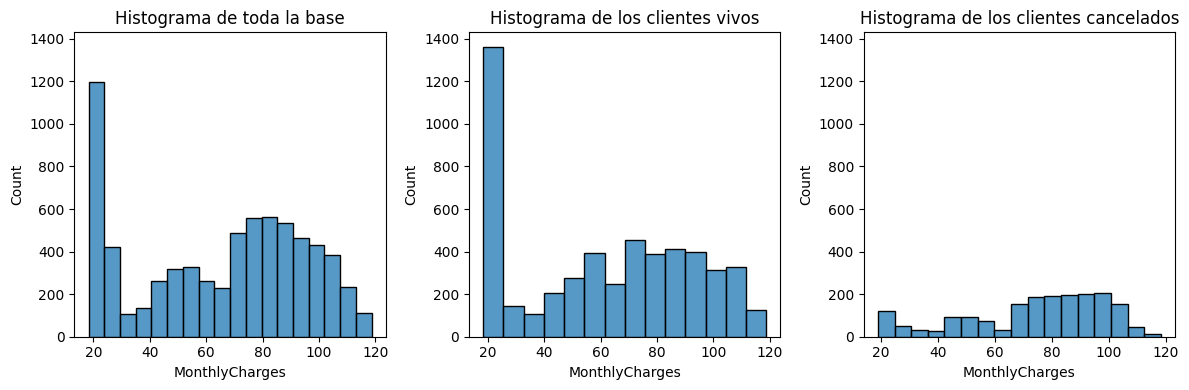

In [32]:
figura, cuadrantes= plt.subplots(1,3, figsize=(12,4))

sns.histplot(data = df, x ='MonthlyCharges', ax = cuadrantes[0])
cuadrantes[0].set_title('Histograma de toda la base')
sns.histplot(data = df_vivos, x ='MonthlyCharges', ax = cuadrantes[1])
cuadrantes[1].set_title('Histograma de los clientes vivos')
sns.histplot(data = df_cancelado, x='MonthlyCharges',ax = cuadrantes[2])
cuadrantes[2].set_title('Histograma de los clientes cancelados')
# Obtener el límite máximo del eje y entre todos los histogramas
y_max = max(
    cuadrantes[0].get_ylim()[1],  # Límite superior del eje y en el primer gráfico
    cuadrantes[1].get_ylim()[1],  # Límite superior del eje y en el segundo gráfico
    cuadrantes[2].get_ylim()[1]   # Límite superior del eje y en el tercer gráfico
)

# Establecer los mismos límites para el eje y en todos los subgráficos
for ax in cuadrantes:
    ax.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

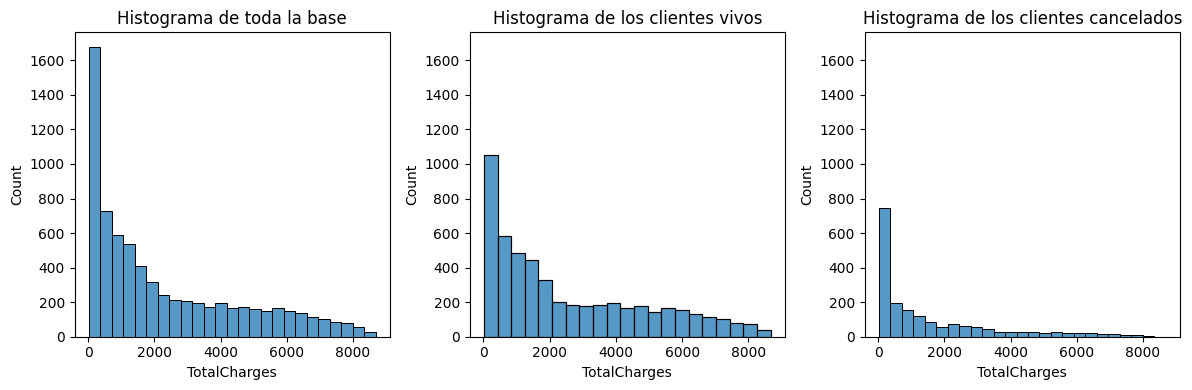

In [33]:
figura, cuadrantes= plt.subplots(1,3, figsize=(12,4))

sns.histplot(data = df, x ='TotalCharges', ax = cuadrantes[0])
cuadrantes[0].set_title('Histograma de toda la base')
sns.histplot(data = df_vivos, x ='TotalCharges', ax = cuadrantes[1])
cuadrantes[1].set_title('Histograma de los clientes vivos')
sns.histplot(data = df_cancelado, x='TotalCharges',ax = cuadrantes[2])
cuadrantes[2].set_title('Histograma de los clientes cancelados')
# Obtener el límite máximo del eje y entre todos los histogramas
y_max = max(
    cuadrantes[0].get_ylim()[1],  # Límite superior del eje y en el primer gráfico
    cuadrantes[1].get_ylim()[1],  # Límite superior del eje y en el segundo gráfico
    cuadrantes[2].get_ylim()[1]   # Límite superior del eje y en el tercer gráfico
)

# Establecer los mismos límites para el eje y en todos los subgráficos
for ax in cuadrantes:
    ax.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

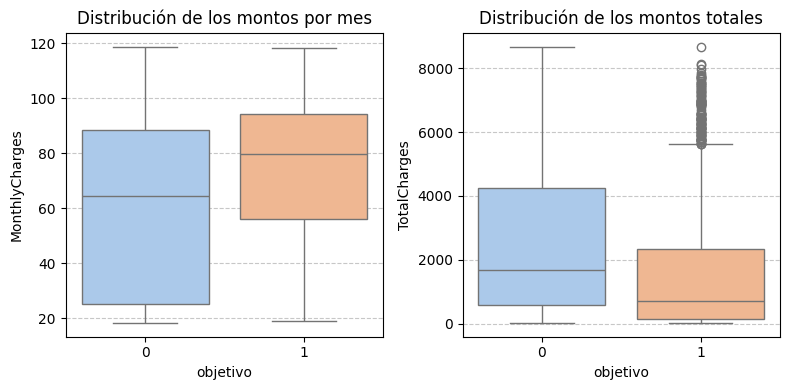

In [34]:
figura, cuadrantes= plt.subplots(1,2, figsize=(8,4))

sns.boxplot(x= "objetivo", y= "MonthlyCharges", data= df, hue= "objetivo", palette='pastel', ax = cuadrantes[0])
cuadrantes[0].set_title('Distribución de los montos por mes')
cuadrantes[0].grid(True, axis='y', linestyle='--', alpha=0.7)
cuadrantes[0].legend().set_visible(False)  # Eliminar la leyenda

sns.boxplot(x= "objetivo", y= "TotalCharges", data= df, hue= "objetivo", palette='pastel', ax = cuadrantes[1])
cuadrantes[1].set_title('Distribución de los montos totales')
cuadrantes[1].grid(True, axis='y', linestyle='--', alpha=0.7)
cuadrantes[1].legend().set_visible(False)  # Eliminar la leyenda

plt.tight_layout()
plt.show()

**Observaciones**
- la mayoria de los clientes que han cancelado pagan mensualmente entre 58 y 93.
- la mayoria de los clientes que han cancelado pagaron en total entre 100 y 2200 aproximadamente. 

In [35]:
df_cancelado["EndDate"] = pd.to_datetime(df_cancelado["EndDate"])
print(df_cancelado.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1869 entries, 2 to 7030
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        1869 non-null   object        
 1   BeginDate         1869 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              1869 non-null   object        
 4   PaperlessBilling  1869 non-null   object        
 5   PaymentMethod     1869 non-null   object        
 6   MonthlyCharges    1869 non-null   float64       
 7   TotalCharges      1869 non-null   float64       
 8   gender            1869 non-null   object        
 9   SeniorCitizen     1869 non-null   object        
 10  Partner           1869 non-null   object        
 11  Dependents        1869 non-null   object        
 12  MultipleLines     1699 non-null   object        
 13  InternetService   1756 non-null   object        
 14  OnlineSecurity    1756 non-nu

C:\Users\snede\AppData\Local\Temp\ipykernel_12452\3921637221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancelado["EndDate"] = pd.to_datetime(df_cancelado["EndDate"])


In [36]:
df_cancelado["meses_activo"]= ((df_cancelado["EndDate"].dt.year - df_cancelado["BeginDate"].dt.year) * 12) + (df_cancelado["EndDate"].dt.month - df_cancelado["BeginDate"].dt.month)
display(df_cancelado.head())


C:\Users\snede\AppData\Local\Temp\ipykernel_12452\4126973006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancelado["meses_activo"]= ((df_cancelado["EndDate"].dt.year - df_cancelado["BeginDate"].dt.year) * 12) + (df_cancelado["EndDate"].dt.month - df_cancelado["BeginDate"].dt.month)


customerID  BeginDate    EndDate            Type PaperlessBilling  \
2   3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
4   9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   
5   9305-CDSKC 2019-03-01 2019-11-01  Month-to-month              Yes   
8   7892-POOKP 2017-07-01 2019-11-01  Month-to-month              Yes   
13  0280-XJGEX 2015-09-01 2019-10-01  Month-to-month              Yes   

                PaymentMethod  MonthlyCharges  TotalCharges  gender  \
2                Mailed check           53.85        108.15    Male   
4            Electronic check           70.70        151.65  Female   
5            Electronic check           99.65        820.50  Female   
8            Electronic check          104.80       3046.05  Female   
13  Bank transfer (automatic)          103.70       5036.30    Male   

   SeniorCitizen  ... MultipleLines InternetService OnlineSecurity  \
2          False  ...            No             DSL            Yes   
4          False  ...            No     Fiber optic             No   
5          False  ...           Yes     Fiber optic             No   
8          False  ...           Yes     Fiber optic             No   
13         False  ...           Yes     Fiber optic             No   

   OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
2           Yes               No          No          No              No   
4            No               No          No          No              No   
5            No              Yes          No         Yes             Yes   
8            No              Yes         Yes         Yes             Yes   
13          Yes              Yes          No         Yes             Yes   

   objetivo meses_activo  
2         1            2  
4         1            2  
5         1            8  
8         1           28  
13        1           49  

[5 rows x 22 columns]

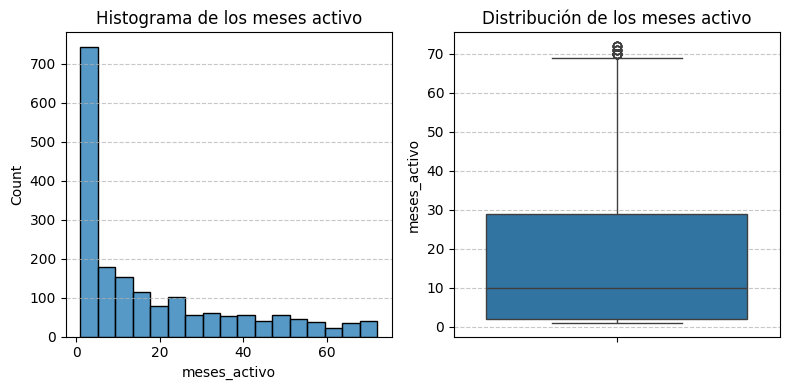

In [37]:
figura, cuadrantes= plt.subplots(1,2, figsize=(8,4))

sns.histplot(data = df_cancelado, x ='meses_activo', ax = cuadrantes[0])
cuadrantes[0].set_title('Histograma de los meses activo')
cuadrantes[0].grid(True, axis='y', linestyle='--', alpha=0.7)

sns.boxplot(y= "meses_activo", data= df_cancelado, ax = cuadrantes[1])
cuadrantes[1].set_title('Distribución de los meses activo')
cuadrantes[1].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Por lo anterior, la mayoría de los clientes cancelan entre 2 a 29 meses de haber iniciado el servicio. 

In [38]:

df_cancelado_categoricas= df_cancelado.drop(["customerID", "BeginDate", "EndDate", "MonthlyCharges", "TotalCharges", "meses_activo", "objetivo"], axis= "columns")
df_cancelado_categoricas_proporciones = df_cancelado_categoricas.apply(lambda col: col.value_counts(dropna= False ,normalize= True).round(2))
display(df_cancelado_categoricas_proporciones)


Type  PaperlessBilling  PaymentMethod  gender  \
Bank transfer (automatic)   NaN               NaN           0.14     NaN   
Credit card (automatic)     NaN               NaN           0.12     NaN   
DSL                         NaN               NaN            NaN     NaN   
Electronic check            NaN               NaN           0.57     NaN   
False                       NaN               NaN            NaN     NaN   
Female                      NaN               NaN            NaN     0.5   
Fiber optic                 NaN               NaN            NaN     NaN   
Mailed check                NaN               NaN           0.16     NaN   
Male                        NaN               NaN            NaN     0.5   
Month-to-month             0.89               NaN            NaN     NaN   
No                          NaN              0.25            NaN     NaN   
One year                   0.09               NaN            NaN     NaN   
True                        NaN               NaN            NaN     NaN   
Two year                   0.03               NaN            NaN     NaN   
Yes                         NaN              0.75            NaN     NaN   
NaN                         NaN               NaN            NaN     NaN   

                           SeniorCitizen  Partner  Dependents  MultipleLines  \
Bank transfer (automatic)            NaN      NaN         NaN            NaN   
Credit card (automatic)              NaN      NaN         NaN            NaN   
DSL                                  NaN      NaN         NaN            NaN   
Electronic check                     NaN      NaN         NaN            NaN   
False                               0.75      NaN         NaN            NaN   
Female                               NaN      NaN         NaN            NaN   
Fiber optic                          NaN      NaN         NaN            NaN   
Mailed check                         NaN      NaN         NaN            NaN   
Male                                 NaN      NaN         NaN            NaN   
Month-to-month                       NaN      NaN         NaN            NaN   
No                                   NaN     0.64        0.83           0.45   
One year                             NaN      NaN         NaN            NaN   
True                                0.25      NaN         NaN            NaN   
Two year                             NaN      NaN         NaN            NaN   
Yes                                  NaN     0.36        0.17           0.45   
NaN                                  NaN      NaN         NaN           0.09   

                           InternetService  OnlineSecurity  OnlineBackup  \
Bank transfer (automatic)              NaN             NaN           NaN   
Credit card (automatic)                NaN             NaN           NaN   
DSL                                   0.25             NaN           NaN   
Electronic check                       NaN             NaN           NaN   
False                                  NaN             NaN           NaN   
Female                                 NaN             NaN           NaN   
Fiber optic                           0.69             NaN           NaN   
Mailed check                           NaN             NaN           NaN   
Male                                   NaN             NaN           NaN   
Month-to-month                         NaN             NaN           NaN   
No                                     NaN            0.78          0.66   
One year                               NaN             NaN           NaN   
True                                   NaN             NaN           NaN   
Two year                               NaN             NaN           NaN   
Yes                                    NaN            0.16          0.28   
NaN                                   0.06            0.06          0.06   

                           DeviceProtection  TechSupport  StreamingTV  \
Bank tr

In [39]:
df_vivos_categoricas= df_vivos.drop(["customerID", "BeginDate", "EndDate", "MonthlyCharges", "TotalCharges", "objetivo"], axis= "columns")
df_vivos_categoricas_proporciones = df_vivos_categoricas.apply(lambda col: col.value_counts(dropna= False ,normalize= True).round(2))
display(df_vivos_categoricas_proporciones)

Type  PaperlessBilling  PaymentMethod  gender  \
Bank transfer (automatic)   NaN               NaN           0.25     NaN   
Credit card (automatic)     NaN               NaN           0.25     NaN   
DSL                         NaN               NaN            NaN     NaN   
Electronic check            NaN               NaN           0.25     NaN   
False                       NaN               NaN            NaN     NaN   
Female                      NaN               NaN            NaN    0.49   
Fiber optic                 NaN               NaN            NaN     NaN   
Mailed check                NaN               NaN           0.25     NaN   
Male                        NaN               NaN            NaN    0.51   
Month-to-month             0.43               NaN            NaN     NaN   
No                          NaN              0.46            NaN     NaN   
One year                   0.25               NaN            NaN     NaN   
True                        NaN               NaN            NaN     NaN   
Two year                   0.32               NaN            NaN     NaN   
Yes                         NaN              0.54            NaN     NaN   
NaN                         NaN               NaN            NaN     NaN   

                           SeniorCitizen  Partner  Dependents  MultipleLines  \
Bank transfer (automatic)            NaN      NaN         NaN            NaN   
Credit card (automatic)              NaN      NaN         NaN            NaN   
DSL                                  NaN      NaN         NaN            NaN   
Electronic check                     NaN      NaN         NaN            NaN   
False                               0.87      NaN         NaN            NaN   
Female                               NaN      NaN         NaN            NaN   
Fiber optic                          NaN      NaN         NaN            NaN   
Mailed check                         NaN      NaN         NaN            NaN   
Male                                 NaN      NaN         NaN            NaN   
Month-to-month                       NaN      NaN         NaN            NaN   
No                                   NaN     0.47        0.66           0.49   
One year                             NaN      NaN         NaN            NaN   
True                                0.13      NaN         NaN            NaN   
Two year                             NaN      NaN         NaN            NaN   
Yes                                  NaN     0.53        0.34           0.41   
NaN                                  NaN      NaN         NaN           0.10   

                           InternetService  OnlineSecurity  OnlineBackup  \
Bank transfer (automatic)              NaN             NaN           NaN   
Credit card (automatic)                NaN             NaN           NaN   
DSL                                   0.38             NaN           NaN   
Electronic check                       NaN             NaN           NaN   
False                                  NaN             NaN           NaN   
Female                                 NaN             NaN           NaN   
Fiber optic                           0.35             NaN           NaN   
Mailed check                           NaN             NaN           NaN   
Male                                   NaN             NaN           NaN   
Month-to-month                         NaN             NaN           NaN   
No                                     NaN            0.39          0.36   
One year                               NaN             NaN           NaN   
True                                   NaN             NaN           NaN   
Two year                               NaN             NaN           NaN   
Yes                                    NaN            0.33          0.37   
NaN                                   0.27            0.27          0.27   

                           DeviceProtection  TechSupport  StreamingTV  \
Bank tr

In [40]:
dudas_columnas = ["gender",'SeniorCitizen', 'Partner',  'Dependents',  'OnlineSecurity',  'OnlineBackup',  'DeviceProtection',  'TechSupport',  'StreamingTV',  'StreamingMovies']
for i in dudas_columnas:
    print("Base_completa", df_categoricas_proporciones[i].dropna())
    print("vivos", df_vivos_categoricas_proporciones[i].dropna()) 
    print("cancelado", df_cancelado_categoricas_proporciones[i].dropna())
    print("-"*50)

Base_completa Female    0.5
Male      0.5
Name: gender, dtype: float64
vivos Female    0.49
Male      0.51
Name: gender, dtype: float64
cancelado Female    0.5
Male      0.5
Name: gender, dtype: float64
--------------------------------------------------
Base_completa False    0.84
True     0.16
Name: SeniorCitizen, dtype: float64
vivos False    0.87
True     0.13
Name: SeniorCitizen, dtype: float64
cancelado False    0.75
True     0.25
Name: SeniorCitizen, dtype: float64
--------------------------------------------------
Base_completa No     0.52
Yes    0.48
Name: Partner, dtype: float64
vivos No     0.47
Yes    0.53
Name: Partner, dtype: float64
cancelado No     0.64
Yes    0.36
Name: Partner, dtype: float64
--------------------------------------------------
Base_completa No     0.7
Yes    0.3
Name: Dependents, dtype: float64
vivos No     0.66
Yes    0.34
Name: Dependents, dtype: float64
cancelado No     0.83
Yes    0.17
Name: Dependents, dtype: float64
-------------------------------

Por lo anterior, analizamos los patrones dado si los clientes cancelaron o no el servicio.

- La columna "Gender" tiene la misma distribución en los 3 dataframes, por lo que es un serio candidato para no usarla en los modelos.

### Buscar patrones de las características y como estás influyen si han cancelado.

Vamos a ver como se distribuye los clientes que han cancelado de acuerdo a cada categória de nuestras columnas para ver el peso de cada una de estas.

In [41]:
for i in dudas_columnas:
    print(df.groupby(by=i)["objetivo"].mean())
    print("-"*50)

gender
Female    0.269595
Male      0.262046
Name: objetivo, dtype: float64
--------------------------------------------------
SeniorCitizen
False    0.236503
True     0.416813
Name: objetivo, dtype: float64
--------------------------------------------------
Partner
No     0.329761
Yes    0.197171
Name: objetivo, dtype: float64
--------------------------------------------------
Dependents
No     0.312791
Yes    0.155312
Name: objetivo, dtype: float64
--------------------------------------------------
OnlineSecurity
No     0.417787
Yes    0.146402
Name: objetivo, dtype: float64
--------------------------------------------------
OnlineBackup
No     0.399417
Yes    0.215670
Name: objetivo, dtype: float64
--------------------------------------------------
DeviceProtection
No     0.391403
Yes    0.225393
Name: objetivo, dtype: float64
--------------------------------------------------
TechSupport
No     0.416475
Yes    0.151961
Name: objetivo, dtype: float64
--------------------------------

Por lo anterior, las columnas o características que vamos a eliminar serán:
'customerID',
'BeginDate',
'EndDate',
'gender'

Y nuestra columna objetivo será "objetivo" recordando que 1 es si el cliente cancelo y 0 si el cliente continua con el servicio.


## Pasos previo a la creación de modelos

En esta parte, vamos a definir con cuales características usaremos para alimentar a nuestros modelos.
También, veremos que hacer con los valores nulos que tenemos. Y dado que tenemos características categoricas y númericas, usaremos one hot encoding y estarizar los datos. Además, dividiremos la base en dos partes entrenamiento y validación. Por último, crearemos una función para evaluar los modelos.

In [42]:
data = df.drop(["customerID", "BeginDate", "EndDate", "gender"], axis= "columns")
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   SeniorCitizen     7032 non-null   object 
 6   Partner           7032 non-null   object 
 7   Dependents        7032 non-null   object 
 8   MultipleLines     6352 non-null   object 
 9   InternetService   5512 non-null   object 
 10  OnlineSecurity    5512 non-null   object 
 11  OnlineBackup      5512 non-null   object 
 12  DeviceProtection  5512 non-null   object 
 13  TechSupport       5512 non-null   object 
 14  StreamingTV       5512 non-null   object 
 15  StreamingMovies   5512 non-null   object 
 16  objetivo          7032 non-null   int64  


Por lo anterior, sabemos que hay clientes que sólo tiene telefónia o internet entonces tenemos valores nulos y esto causará problemas en el entrenamiento de los modelos, por lo que vamos a crear una nueva categória llamada "sin servicio".


In [43]:
data= data.fillna("sin_servicio")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   SeniorCitizen     7032 non-null   object 
 6   Partner           7032 non-null   object 
 7   Dependents        7032 non-null   object 
 8   MultipleLines     7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  objetivo          7032 non-null   int64  


### One hot encoding

In [44]:
data_ohe= pd.get_dummies(data, drop_first=True)
display(data_ohe)

MonthlyCharges  TotalCharges  objetivo  Type_One year  Type_Two year  \
0              29.85         29.85         0          False          False   
1              56.95       1889.50         0           True          False   
2              53.85        108.15         1          False          False   
3              42.30       1840.75         0           True          False   
4              70.70        151.65         1          False          False   
...              ...           ...       ...            ...            ...   
7027           84.80       1990.50         0           True          False   
7028          103.20       7362.90         0           True          False   
7029           29.60        346.45         0          False          False   
7030           74.40        306.60         1          False          False   
7031          105.65       6844.50         0          False           True   

      PaperlessBilling_Yes  PaymentMethod_Credit card (automatic)  \
0                     True                                  False   
1                    False                                  False   
2                     True                                  False   
3                    False                                  False   
4                     True                                  False   
...                    ...                                    ...   
7027                  True                                  False   
7028                  True                                   True   
7029                  True                                  False   
7030                  True                                  False   
7031                  True                                  False   

      PaymentMethod_Electronic check  PaymentMethod_Mailed check  \
0                               True                       False   
1                              False                        True   
2                              False                        True   
3                              False                       False   
4                               True                       False   
...                              ...                         ...   
7027                           False                        True   
7028                           False                       False   
7029                            True                       False   
7030                           False                        True   
7031                           False                       False   

      SeniorCitizen_True  ...  OnlineBackup_Yes  OnlineBackup_sin_servicio  \
0                  False  ...              True                      False   
1                  False  ...             False                      False   
2                  False  ...              True                      False   
3                  False  ...             False                      False   
4                  False  ...             False                      False   
...                  ...  ...               ...                        ...   
7027               False  ...             False                      False   
7028               False  ...              True                      False   
7029               False  ...             False                      False   
7030                True  ...             False                      False   
7031               False  ...             False                      False   

      DeviceProtection_Yes  DeviceProtection_sin_servicio  TechSupport_Yes  \
0                    False                          False            False   
1                     True                          False            False   
2                    False                          False            False   
3                     True                          False             True   
4                    False                          False            False   
...               

### Dividir la base

Para este paso vamos a dividir la base de la siguiente manera (75, 25) que será para el entrenamiento y validación. Esto se hará así, porque usaremos GridSearchCV para la valoración de los hiperparámetros que usaremos en cada modelo, recordar que está herramiento usa validación cruzada para evaluar el rendimiento de cada combinación de hiperparámetros.


In [45]:
features= data_ohe.drop("objetivo", axis= "columns")
target= data_ohe["objetivo"]

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size= 0.25, random_state= 12345)

print(features_train.shape)
print(target_train.shape)
print("-"*50)
print(features_valid.shape)
print(target_valid.shape)


(5274, 27)
(5274,)
--------------------------------------------------
(1758, 27)
(1758,)


### Estandarizar

In [46]:
numeric= ["MonthlyCharges", "TotalCharges"]
scaler= StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

display(features_train.head())
display(features_valid.head())
print(features_train[numeric].describe())
print(features_valid[numeric].describe())

MonthlyCharges  TotalCharges  Type_One year  Type_Two year  \
5486        0.296184     -0.604484          False          False   
2004        0.475876      1.507270          False           True   
1795       -0.702104     -0.992243          False          False   
5621        1.281161      0.743794          False          False   
6286       -1.489087     -0.560101          False           True   

      PaperlessBilling_Yes  PaymentMethod_Credit card (automatic)  \
5486                  True                                  False   
2004                  True                                  False   
1795                  True                                  False   
5621                  True                                  False   
6286                 False                                  False   

      PaymentMethod_Electronic check  PaymentMethod_Mailed check  \
5486                            True                       False   
2004                           False                       False   
1795                           False                       False   
5621                            True                       False   
6286                           False                       False   

      SeniorCitizen_True  Partner_Yes  ...  OnlineBackup_Yes  \
5486               False        False  ...             False   
2004               False         True  ...              True   
1795               False        False  ...             False   
5621               False        False  ...              True   
6286               False         True  ...             False   

      OnlineBackup_sin_servicio  DeviceProtection_Yes  \
5486                      False                 False   
2004                      False                  True   
1795                      False                 False   
5621                      False                  True   
6286                       True                 False   

      DeviceProtection_sin_servicio  TechSupport_Yes  \
5486                          False             True   
2004                          False             True   
1795                          False            False   
5621                          False            False   
6286                           True            False   

      TechSupport_sin_servicio  StreamingTV_Yes  StreamingTV_sin_servicio  \
5486                     False            False                     False   
2004                     False             True                     False   
1795                     False            False                     False   
5621                     False             True                     False   
6286                      True            False                      True   

      StreamingMovies_Yes  StreamingMovies_sin_servicio  
5486                False                         False  
2004                False                         False  
1795                False                         False  
5621                 True                         False  
6286                False                          True  

[5 rows x 27 columns]

MonthlyCharges  TotalCharges  Type_One year  Type_Two year  \
3276        0.993321      1.049729          False           True   
1620        0.359409     -0.723286          False          False   
4598       -1.329361     -0.879374          False           True   
5434       -0.648862     -0.469621          False          False   
2757        1.143064      0.093011          False           True   

      PaperlessBilling_Yes  PaymentMethod_Credit card (automatic)  \
3276                  True                                  False   
1620                  True                                  False   
4598                 False                                  False   
5434                 False                                  False   
2757                 False                                  False   

      PaymentMethod_Electronic check  PaymentMethod_Mailed check  \
3276                            True                       False   
1620                           False                       False   
4598                           False                        True   
5434                            True                       False   
2757                           False                       False   

      SeniorCitizen_True  Partner_Yes  ...  OnlineBackup_Yes  \
3276               False         True  ...              True   
1620               False         True  ...             False   
4598               False         True  ...             False   
5434               False        False  ...             False   
2757               False        False  ...             False   

      OnlineBackup_sin_servicio  DeviceProtection_Yes  \
3276                      False                 False   
1620                      False                  True   
4598                       True                 False   
5434                      False                 False   
2757                      False                  True   

      DeviceProtection_sin_servicio  TechSupport_Yes  \
3276                          False            False   
1620                          False            False   
4598                           True            False   
5434                          False            False   
2757                          False             True   

      TechSupport_sin_servicio  StreamingTV_Yes  StreamingTV_sin_servicio  \
3276                     False             True                     False   
1620                     False            False                     False   
4598                      True            False                      True   
5434                     False            False                     False   
2757                     False             True                     False   

      StreamingMovies_Yes  StreamingMovies_sin_servicio  
3276                 True                         False  
1620                False                         False  
4598                False                          True  
5434                False                         False  
2757                 True                         False  

[5 rows x 27 columns]

       MonthlyCharges  TotalCharges
count    5.274000e+03  5.274000e+03
mean    -2.681039e-16 -1.492086e-16
std      1.000095e+00  1.000095e+00
min     -1.553976e+00 -1.003251e+00
25%     -9.716413e-01 -8.336889e-01
50%      1.822127e-01 -3.893255e-01
75%      8.302677e-01  6.786145e-01
max      1.790288e+00  2.804904e+00
       MonthlyCharges  TotalCharges
count     1758.000000   1758.000000
mean        -0.020103     -0.032589
std          1.004437      0.983902
min         -1.535674     -1.003229
25%         -0.994519     -0.842955
50%          0.171398     -0.422887
75%          0.824860      0.597154
max          1.786960      2.765179


### Función para evaluar los modelos

In [47]:
def eval_model(y, y_predict, probabilities):
    accuracy = accuracy_score(y, y_predict)
    precision = precision_score(y, y_predict)
    recall = recall_score(y, y_predict)
    f1 = f1_score(y, y_predict)
        
    #print(f'Exactitud: {accuracy_score(y, y_predict):,.3f}')
    print(f'Matriz de confusión: \n{confusion_matrix(y, y_predict, normalize= "all").round(3)}')
    #print(f'Precisión: {precision_score(y, y_predict):,.3f}')
    #print(f'Recall: {recall_score(y, y_predict):,.3f}')
    #print(f'F1: {f1_score(y, y_predict):,.3f}')
    
    probabilities_one = probabilities[:, 1]
    auc_roc= roc_auc_score(y, probabilities_one)
    
    print(f'Puntuación de la curva AUC-ROC: {auc_roc:,.3f}')

    fpr, tpr, thresholds= roc_curve(y, probabilities_one)
    plt.figure()
    plt.plot(fpr, tpr)
    #Curva ROC para modelo aleatorio (la linea diagonal)
    plt.plot([0,1], [0,1], linestyle= "--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("Tasa de falsos positivos")
    plt.ylabel("Tasa de verdaderos positivos")
    plt.title("Curva ROC")
    plt.show()

    # Calcular el F1-score para cada umbral
    f1_scores = []
    for threshold in thresholds:
    # Clasificar según el umbral actual
        y_pred_class = (probabilities_one >= threshold).astype(int)
        f1_scores.append(f1_score(y, y_pred_class))
    # Encontrar el umbral que maximiza el F1-score
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)

    # Mostrar el mejor umbral y el F1-score correspondiente
    print(f"El mejor umbral de clasificación es {best_threshold:.2f} con un F1-score de {best_f1:.2f}")

    # Graficar la curva ROC y el F1-score
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, f1_scores, label='F1-score', color='green')
    plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel('Umbral de Clasificación')
    plt.ylabel('F1-score')
    plt.title('F1-score vs Umbral de Clasificación')
    plt.legend(loc='best')
    plt.show()

    metrics= {
        "AUC-ROC": round(auc_roc, 3),
        "Accuracy": round(accuracy, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1": round(f1, 3)
    }
    return metrics


    

## Elaboración de modelos

### Prueba de cordura


objetivo
0    0.73
1    0.27
Name: proportion, dtype: float64


<Axes: xlabel='objetivo'>

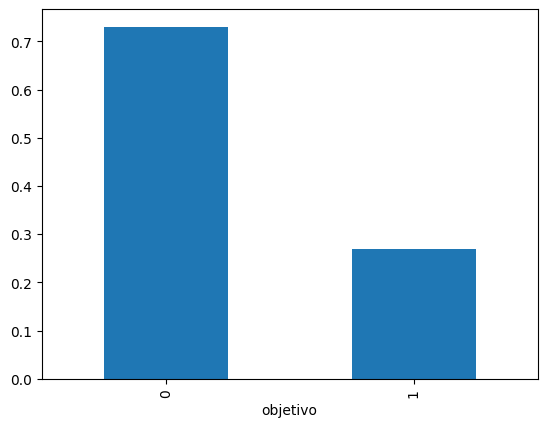

In [48]:
class_frequency= target.value_counts(normalize= True).round(2)
print(class_frequency)
class_frequency.plot(kind= "bar")

Por lo anterior, vamos a crear un modelo que a todos los clientes asigne 1 que en este caso sería que siguen contando con el servicio.

In [49]:
target_predict_constan= pd.Series(1, index= target.index)
print(f'Exactitud: {accuracy_score(target, target_predict_constan):,.3f}')
print(f'Matriz de confusión: \n{confusion_matrix(target, target_predict_constan, normalize= "all")}')
print(f'Recall: {recall_score(target, target_predict_constan):,.3f}')
print(f'F1: {f1_score(target, target_predict_constan):,.3f}')



Exactitud: 0.266
Matriz de confusión: 
[[0.         0.73421502]
 [0.         0.26578498]]
Recall: 1.000
F1: 0.420


En conclusión, nuestra prueba de cordura asignamos todos los valores a 1, nuestra precisión equivalente al desequilibrio de la clase y claramente esto afecta a la métrica de F1. Pero es un punto de partida para nuestros siguientes modelos.

### Modelo Árbol

In [50]:
tree = DecisionTreeClassifier(random_state= 12345)
param_grid= {
    'max_depth': [2, 5, 7, 10, 20, 30],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 7, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],    # Mínimo número de muestras en un nodo hoja
    'criterion': ['gini', 'entropy'] # Criterio para medir la calidad de la división
}
#refit; el modelo será optimizado para F1-score, pero podrás ver las puntuaciones tanto de precisión como de F1 durante la búsqueda.
grid_search_tree = GridSearchCV(estimator= tree, param_grid=param_grid, cv=5, scoring= ["accuracy", "f1"], refit='f1')

grid_search_tree.fit(features_train, target_train)

# Mejor conjunto de parámetros
print("Mejores parámetros encontrados:", grid_search_tree.best_params_)

# Mejor puntuación de validación cruzada (según la primera métrica, en este caso 'accuracy')
print("Mejor puntuación de validación cruzada (Accuracy):", grid_search_tree.best_score_)

# Para obtener las puntuaciones de ambas métricas (Accuracy y F1) en cada combinación de parámetros
# Usamos cv_results_ y accedemos a las puntuaciones de cada métrica
print("Mejor puntuación de validación cruzada (F1):", grid_search_tree.cv_results_['mean_test_f1'][grid_search_tree.best_index_])


best_tree = grid_search_tree.best_estimator_
print(best_tree)



Mejores parámetros encontrados: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}
Mejor puntuación de validación cruzada (Accuracy): 0.5551119493150323
Mejor puntuación de validación cruzada (F1): 0.5551119493150323
DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=4,
                       random_state=12345)


c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Matriz de confusión: 
[[0.649 0.086]
 [0.121 0.144]]
Puntuación de la curva AUC-ROC: 0.827


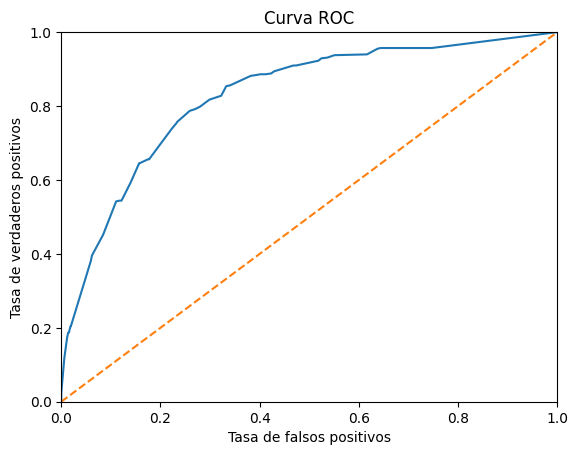

El mejor umbral de clasificación es 0.32 con un F1-score de 0.63


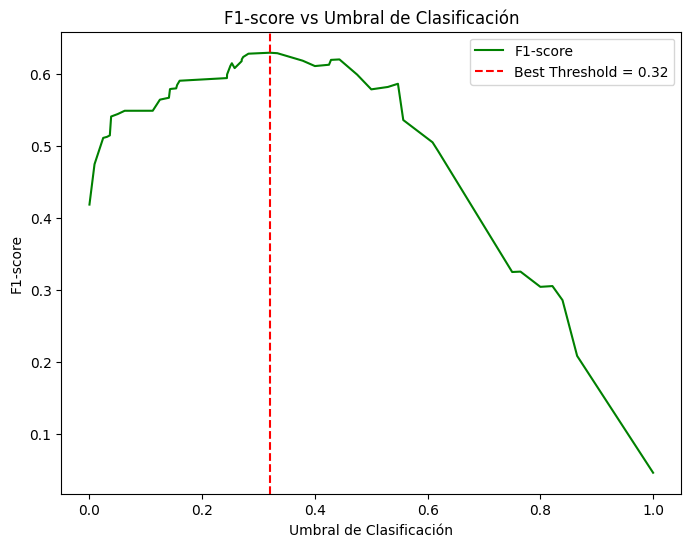

{'AUC-ROC': 0.827, 'Accuracy': 0.793, 'Precision': 0.625, 'Recall': 0.544, 'F1': 0.582}


In [51]:
tree_final = DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=4,
                       random_state=12345)
tree_final.fit(features_train, target_train)
tree_predict= tree_final.predict(features_valid)
probabilities_tree = tree_final.predict_proba(features_valid)

eval_tree = eval_model(target_valid, tree_predict, probabilities_tree)
print(eval_tree)

### Modelo Bosque Aleatorio

### La siguiente celda la deje como markdown ya que tarda más de 30 minutos en compilar dicha celda, sólo sería cambiar el formato de la celda a Code para ver el uso de GridSearchCV

forest = RandomForestClassifier(random_state= 12345)
param_grid_forest= {
    "n_estimators": [10, 50, 75, 100, 150, 200],
    'max_depth': [2, 5, 7, 10, 20, 30, "None"],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 7, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],    # Mínimo número de muestras en un nodo hoja
    'criterion': ['gini', 'entropy', "log_loss"] # Criterio para medir la calidad de la división
}
#refit; el modelo será optimizado para F1-score, pero podrás ver las puntuaciones tanto de precisión como de F1 durante la búsqueda.
grid_search_forest = GridSearchCV(estimator= forest, param_grid= param_grid_forest, cv=5, scoring= ["accuracy", "f1"], refit='f1')

grid_search_forest.fit(features_train, target_train)

# Mejor conjunto de parámetros
print("Mejores parámetros encontrados:", grid_search_forest.best_params_)

# Mejor puntuación de validación cruzada (según la primera métrica, en este caso 'accuracy')
print("Mejor puntuación de validación cruzada (Accuracy):", grid_search_forest.best_score_)

# Para obtener las puntuaciones de ambas métricas (Accuracy y F1) en cada combinación de parámetros
# Usamos cv_results_ y accedemos a las puntuaciones de cada métrica
print("Mejor puntuación de validación cruzada (F1):", grid_search_forest.cv_results_['mean_test_f1'][grid_search_forest.best_index_])


best_forest = grid_search_forest.best_estimator_
print(best_forest)

Matriz de confusión: 
[[0.673 0.062]
 [0.133 0.131]]
Puntuación de la curva AUC-ROC: 0.848


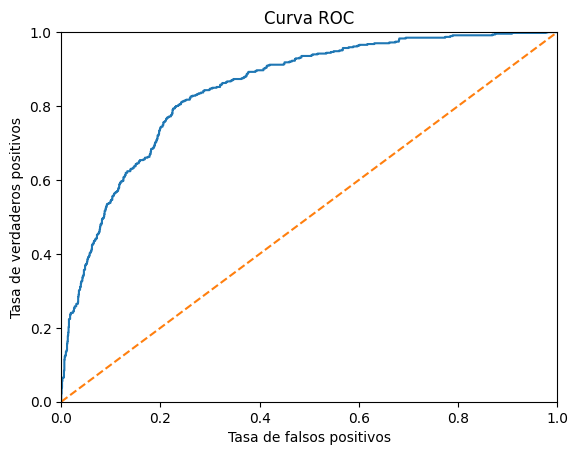

El mejor umbral de clasificación es 0.31 con un F1-score de 0.66


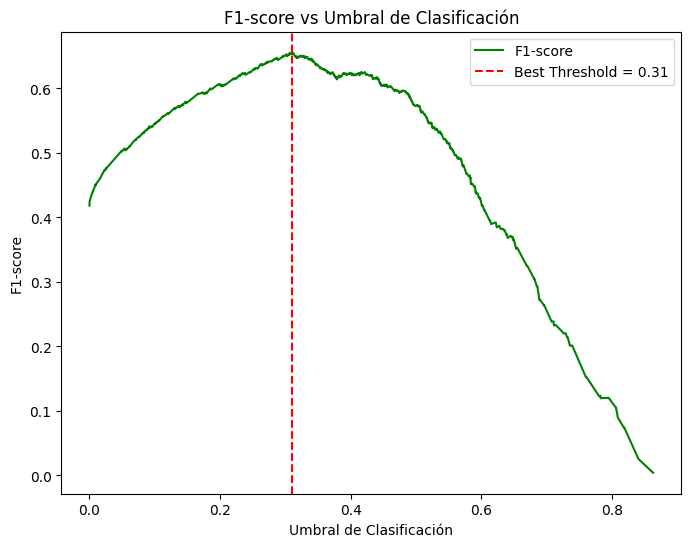

{'AUC-ROC': 0.848, 'Accuracy': 0.805, 'Precision': 0.679, 'Recall': 0.497, 'F1': 0.574}


In [52]:
forest_final= RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=7, min_samples_leaf= 1, random_state=12345)

forest_final.fit(features_train, target_train)

forest_predict = forest_final.predict(features_valid)
probabilities_forest = forest_final.predict_proba(features_valid)

eval_forest= eval_model(target_valid, forest_predict, probabilities_forest)

print(eval_forest)

### Modelo de Regresión Logística

In [53]:
lr = LogisticRegression(random_state= 12345)
param_grid_lr= {
    "solver": ["liblinear", "newton-cholesky"] # son para clasificación binaria
}
#refit; el modelo será optimizado para F1-score, pero podrás ver las puntuaciones tanto de precisión como de F1 durante la búsqueda.
grid_search_lr = GridSearchCV(estimator= lr, param_grid= param_grid_lr, cv=5, scoring= ["accuracy", "f1"], refit='f1')

grid_search_lr.fit(features_train, target_train)

# Mejor conjunto de parámetros
print("Mejores parámetros encontrados:", grid_search_lr.best_params_)

# Mejor puntuación de validación cruzada (según la primera métrica, en este caso 'accuracy')
print("Mejor puntuación de validación cruzada (Accuracy):", grid_search_lr.best_score_)

# Para obtener las puntuaciones de ambas métricas (Accuracy y F1) en cada combinación de parámetros
# Usamos cv_results_ y accedemos a las puntuaciones de cada métrica
print("Mejor puntuación de validación cruzada (F1):", grid_search_lr.cv_results_['mean_test_f1'][grid_search_lr.best_index_])


best_lr = grid_search_lr.best_estimator_
print(best_lr)


Mejores parámetros encontrados: {'solver': 'newton-cholesky'}
Mejor puntuación de validación cruzada (Accuracy): 0.5794757335543725
Mejor puntuación de validación cruzada (F1): 0.5794757335543725
LogisticRegression(random_state=12345, solver='newton-cholesky')


Matriz de confusión: 
[[0.662 0.074]
 [0.12  0.144]]
Puntuación de la curva AUC-ROC: 0.844


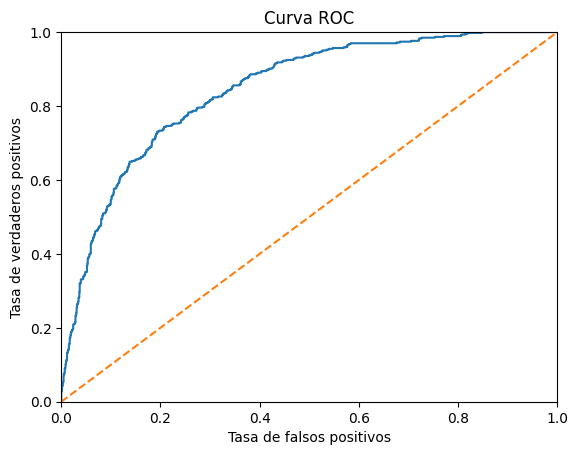

El mejor umbral de clasificación es 0.34 con un F1-score de 0.64


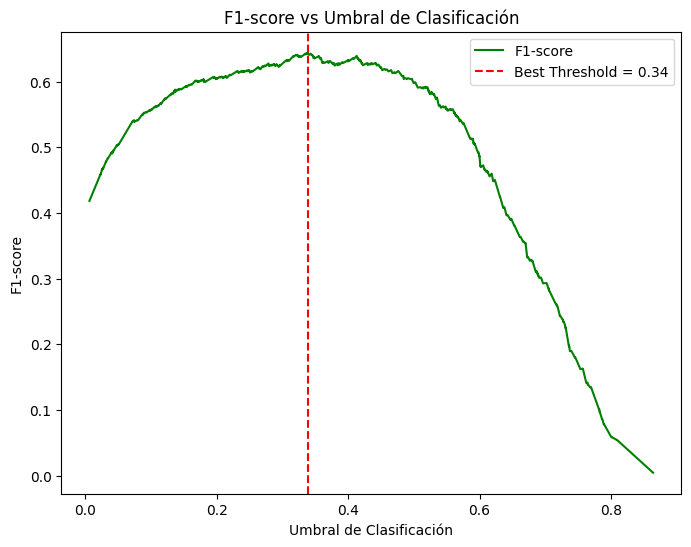

{'AUC-ROC': 0.844, 'Accuracy': 0.806, 'Precision': 0.661, 'Recall': 0.546, 'F1': 0.598}


In [54]:
# 'Newton-Cholesky' es una buena opción para n_samples>> n_features, especialmente con características categóricas codificadas one-hot con categorías poco frecuentes.
lr_final= LogisticRegression(random_state=12345, solver='newton-cholesky')
lr_final.fit(features_train, target_train)

lr_predict = lr_final.predict(features_valid)
probabilities_lr = lr_final.predict_proba(features_valid)

eval_lr = eval_model(target_valid, lr_predict, probabilities_lr)

print(eval_lr)

### Modelo LightGBM (gradient boosting)

In [55]:
model_lgb = lgb.LGBMClassifier(random_state= 12345)
param_grid_model_lgb = {
    'max_depth': [3, 5, 10, 20],  # Profundidad máxima del árbol
    "n_estimators": [25, 50, 100, 200],
    'num_leaves ': [31, 50, 75],  # Mínimo número de muestras para dividir un nodo
    "learning_rate": [0.1, 0.2, 0.3]
}
#refit; el modelo será optimizado para F1-score, pero podrás ver las puntuaciones tanto de precisión como de F1 durante la búsqueda.
grid_search_model_lgb = GridSearchCV(estimator= model_lgb, param_grid=param_grid_model_lgb, cv=5, scoring= ["accuracy", "f1"], refit='f1')

grid_search_model_lgb.fit(features_train, target_train)

# Mejor conjunto de parámetros
print("Mejores parámetros encontrados:", grid_search_model_lgb.best_params_)

# Mejor puntuación de validación cruzada (según la primera métrica, en este caso 'accuracy')
print("Mejor puntuación de validación cruzada (Accuracy):", grid_search_model_lgb.best_score_)

# Para obtener las puntuaciones de ambas métricas (Accuracy y F1) en cada combinación de parámetros
# Usamos cv_results_ y accedemos a las puntuaciones de cada métrica
print("Mejor puntuación de validación cruzada (F1):", grid_search_model_lgb.cv_results_['mean_test_f1'][grid_search_model_lgb.best_index_])


best_model_lgb = grid_search_model_lgb.best_estimator_
print(best_model_lgb)

c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 31
[LightGBM] [Info] Number of positive: 1123, number of negative: 3096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266177 -> initscore=-1.014107
[LightGBM] [Info] Start training from score -1.014107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1404, number of negative: 3870
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 5274, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266212 -> initscore=-1.013929
[LightGBM] [Info] Start training from score -1.013929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

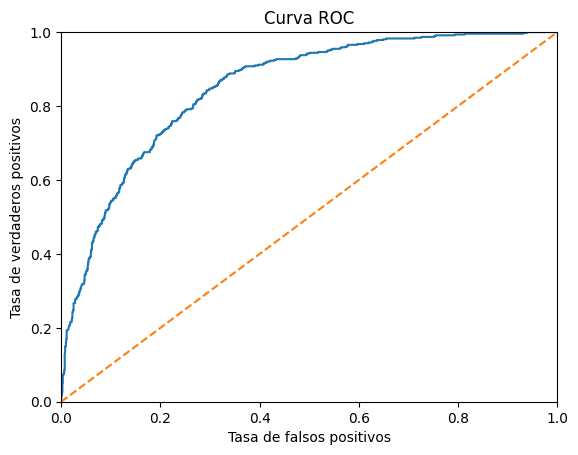

El mejor umbral de clasificación es 0.34 con un F1-score de 0.64


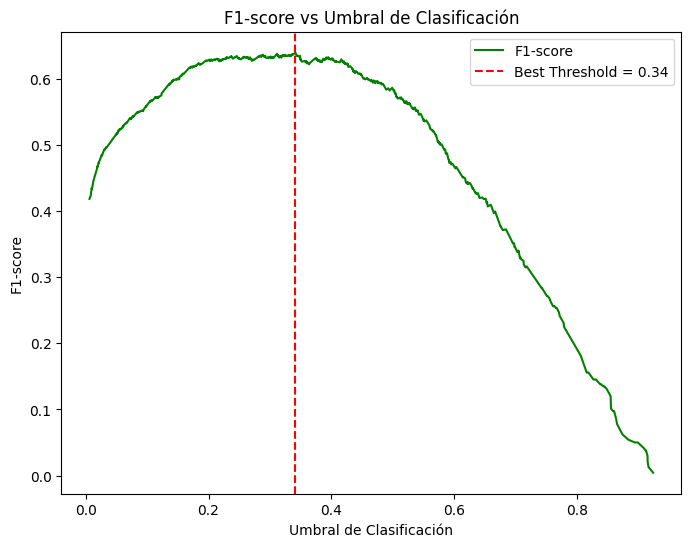

{'AUC-ROC': 0.85, 'Accuracy': 0.805, 'Precision': 0.673, 'Recall': 0.514, 'F1': 0.583}


In [56]:
lgb_final= lgb.LGBMClassifier(max_depth=5, n_estimators=50, num_leaves =31, random_state=12345)

lgb_final.fit(features_train, target_train)
lgb_predict= lgb_final.predict(features_valid)
probabilities_lgb = lgb_final.predict_proba(features_valid)

eval_lgb= eval_model(target_valid, lgb_predict, probabilities_lgb)
print(eval_lgb)


### Modelo de red neuronal

In [57]:
def create_model(num_neurons=64):
    model = Sequential()
    model.add(Dense(num_neurons, input_dim= features_train.shape[1], activation='relu'))  # Capa de entrada con 'num_neurons'
    # Capa oculta 1: Usamos Dropout para evitar sobreajuste (regularización)
    model.add(Dropout(0.3))  # Dropout de 30%
    # Capa oculta adicional
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Envoltorio de Keras para que funcione con GridSearchCV
class KerasClassifierCustom(BaseEstimator):
    def __init__(self, num_neurons=64, batch_size=32, epochs=10):
        self.num_neurons = num_neurons
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None

    def fit(self, X, y):
        self.model = create_model(self.num_neurons)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]  # Retorna precisión

# Convertir la función en un clasificador que se puede usar con GridSearchCV
model = KerasClassifierCustom()


param_grid = {
    'num_neurons': [32, 64, 128],  # Diferentes valores para el número de neuronas
    'batch_size': [32, 64],  # Tamaños de lote
    'epochs': [10, 20]  # Número de épocas
}

# Configurar el GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Ajustar el modelo
grid_result = grid.fit(features_train, target_train)

# Mostrar los mejores parámetros y resultados
print(f"Mejores parámetros: {grid_result.best_params_}")
print(f"Mejor precisión: {grid_result.best_score_}")

best_model = grid_result.best_estimator_
print(best_model)

c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in

Mejores parámetros: {'batch_size': 64, 'epochs': 20, 'num_neurons': 64}
Mejor precisión: 0.8020471930503845
KerasClassifierCustom(batch_size=64, epochs=20)


Epoch 1/10


c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6944 - loss: 0.5542 - val_accuracy: 0.7918 - val_loss: 0.4372
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7846 - loss: 0.4485 - val_accuracy: 0.8003 - val_loss: 0.4255
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7970 - loss: 0.4305 - val_accuracy: 0.7964 - val_loss: 0.4234
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7923 - loss: 0.4308 - val_accuracy: 0.8032 - val_loss: 0.4205
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7965 - loss: 0.4297 - val_accuracy: 0.7998 - val_loss: 0.4207
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7980 - loss: 0.4264 - val_accuracy: 0.7998 - val_loss: 0.4163
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8101 - loss: 0.4170 - val_accuracy: 0.7986 - val_loss: 0.4173
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7974 - loss: 0.4197 - val_accuracy: 0.7986 - val_

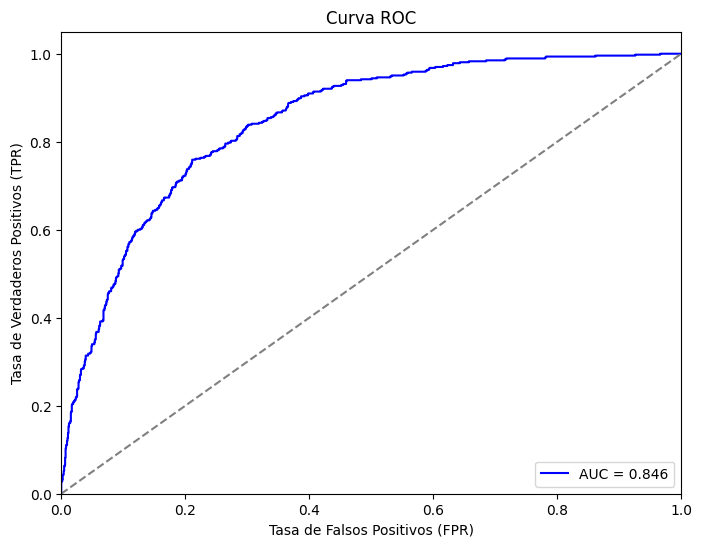

El mejor umbral de clasificación es 0.30 con un F1-score de 0.65


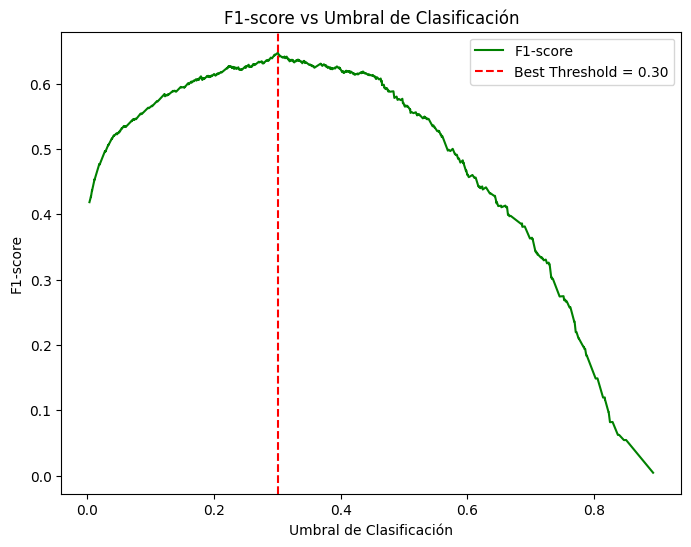

In [58]:
red = Sequential()
red.add(Dense(64, input_dim= features_train.shape[1], activation='relu'))  # Capa de entrada con 'num_neurons'
# Capa oculta 1: Usamos Dropout para evitar sobreajuste (regularización)
red.add(Dropout(0.3))  # Dropout de 30%
# Capa oculta adicional
red.add(Dense(32, activation='relu'))
red.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide
red.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

red.fit(features_train, target_train, epochs=10, batch_size=32, validation_data=(features_valid, target_valid))

# Evaluar el modelo
loss, accuracy = red.evaluate(features_valid, target_valid)
print(f'Loss: {loss:.3f}, Accuracy: {accuracy:.3f}')

# Hacer predicciones
red_predict = (red.predict(features_valid) > 0.5).astype(int)  # Umbral de 0.5 para clasificación binaria
probabilities_red= red.predict(features_valid)
#print(red_predict)
# Puedes calcular métricas adicionales como precisión, recall, f1-score, etc.
print(f'Exactitud: {accuracy_score(target_valid, red_predict):,.3f}')
print(f'Matriz de confusión: \n{confusion_matrix(target_valid, red_predict, normalize= "all").round(3)}')
print(f'Precision: {precision_score(target_valid, red_predict):,.3f}')
print(f'Recall: {recall_score(target_valid, red_predict):,.3f}')
print(f'F1-score: {f1_score(target_valid, red_predict):,.3f}')


roc_auc_red= roc_auc_score(target_valid, probabilities_red)
print(f'ROC AUC Score: {roc_auc_red:,.3f}')

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_red)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc_red:,.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (modelo aleatorio)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Calcular el F1-score para cada umbral
f1_scores = []
for threshold in thresholds:
# Clasificar según el umbral actual
    y_pred_class = (probabilities_red >= threshold).astype(int)
    f1_scores.append(f1_score(target_valid, y_pred_class))
    # Encontrar el umbral que maximiza el F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

# Mostrar el mejor umbral y el F1-score correspondiente
print(f"El mejor umbral de clasificación es {best_threshold:.2f} con un F1-score de {best_f1:.2f}")

    # Graficar la curva ROC y el F1-score
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, label='F1-score', color='green')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Umbral de Clasificación')
plt.ylabel('F1-score')
plt.title('F1-score vs Umbral de Clasificación')
plt.legend(loc='best')
plt.show()

eval_red= {
    "AUC-ROC": round(roc_auc_red, 3),
    "Accuracy": round(accuracy_score(target_valid, red_predict), 3),
    "Precision": round(precision_score(target_valid, red_predict), 3),
    "Recall": round(recall_score(target_valid, red_predict), 3),
    "F1": round(f1_score(target_valid, red_predict), 3)
    }

## Resultados

In [59]:
comparacion= pd.DataFrame([eval_tree, eval_forest, eval_lr, eval_lgb, eval_red], index= ["Árbol", "Bosque aleatorio", "Regresión Logística", "LightGBM", "Red Neuronal"])
display(comparacion)

AUC-ROC  Accuracy  Precision  Recall     F1
Árbol                  0.827     0.793      0.625   0.544  0.582
Bosque aleatorio       0.848     0.805      0.679   0.497  0.574
Regresión Logística    0.844     0.806      0.661   0.546  0.598
LightGBM               0.850     0.805      0.673   0.514  0.583
Red Neuronal           0.846     0.800      0.661   0.499  0.569

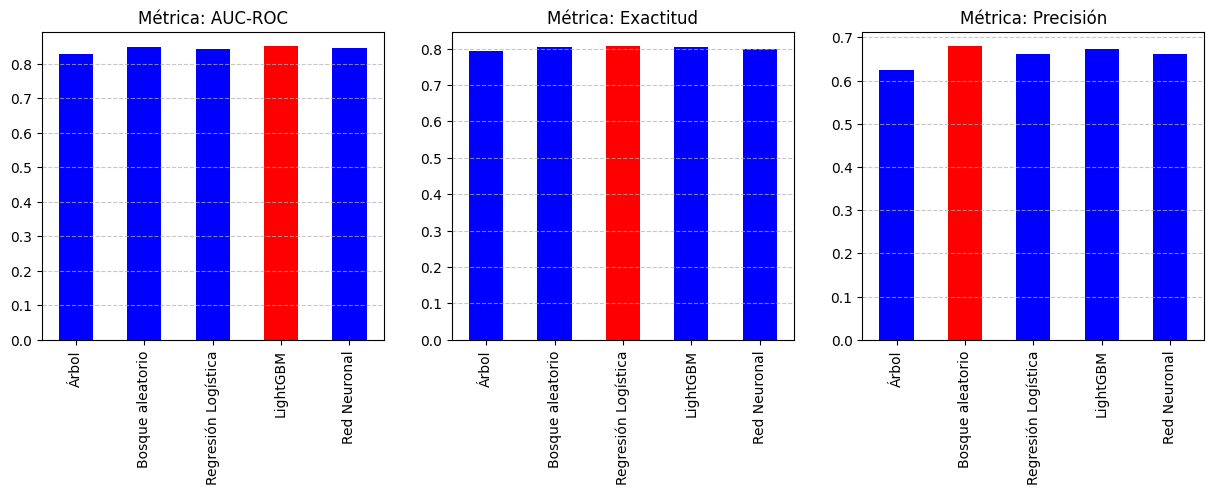

In [60]:
fig, axes = plt.subplots(1,3, figsize=(15,4))

colors_auc_roc = ['blue' if x != comparacion['AUC-ROC'].max() else 'red' for x in comparacion['AUC-ROC']]
colors_accuracy = ['blue' if x != comparacion['Accuracy'].max() else 'red' for x in comparacion['Accuracy']]
colors_precision = ['blue' if x != comparacion['Precision'].max() else 'red' for x in comparacion['Precision']]

comparacion['AUC-ROC'].plot(kind="bar", ax= axes[0], color= colors_auc_roc)
axes[0].set_title("Métrica: AUC-ROC")
axes[0].grid(True, axis='y', linestyle='--', alpha=0.7)

comparacion['Accuracy'].plot(kind="bar", ax= axes[1], color= colors_accuracy)
axes[1].set_title("Métrica: Exactitud")
axes[1].grid(True, axis='y', linestyle='--', alpha=0.7)

comparacion['Precision'].plot(kind="bar", ax= axes[2], color= colors_precision)
axes[2].set_title("Métrica: Precisión")
axes[2].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()


## Conclusiones

- La diferencia entre los modelos no fue tan distinta quitando el modelo de Árbol. Pero el mejor modelo para resolver este problema fue LightGBM ya que obtuvo mayor valor con respecto a la métrica principal AUC-ROC y su precisión fue ligeramente menor con respecto al Bosque Aleatorio.
- Los modelos aún pueden mejorar eliminando más características que su distribución se parecida o en la parte de GridSearchCV tomar como métrica principal la precisión ya que si reducimos los Falsos positivos tendremos menores pérdidas con respecto a las promociones que se enviarían a estos clientes.